In [1]:
import json
from bs4 import BeautifulSoup
import requests
import pandas as pd
import io

In [2]:
# Wikipedia countries list
url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'

# Identify ourselves as per T&Cs
headers = {'User-Agent': 'nelis.drost@auckland.ac.nz'}


In [3]:
# Get page
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table containing the country names and links
table = soup.find('table', class_='wikitable')
rows = table.find_all('tr')

# Print the first few rows
df = pd.read_html(io.StringIO(str(table)))[0]
display(df.head())

  Unnamed: 0       Location  Population % of world         Date  \
0        NaN          World  8115643000       100%  30 Jun 2024   
1        [b]          China  1409670000        NaN  31 Dec 2023   
2        [b]          India  1400744000        NaN   1 Mar 2024   
3          3  United States   335893238        NaN   1 Jan 2024   
4          4      Indonesia   279118866        NaN   1 Jul 2023   

  Source (official or from the United Nations) Unnamed: 6  
0                             UN projection[3]        NaN  
1                         Official estimate[5]        [c]  
2                       Official projection[6]        [d]  
3                         Official estimate[7]        [e]  
4                National annual projection[8]        NaN  


In [4]:
# We want to do something for each row in the table
for row in rows[2:10]:
    pass

In [19]:
# First, lets find the link to the country page
def country_url(row):
    links = row.find_all('a')

    # Filter out internal links (to footnotes)
    links = [link for link in links if link['href'].startswith('/wiki/')]
    if len(links) == 0:
        return None, None

    return 'https://en.wikipedia.org' + links[0]['href'], links[0].text

# Example:
c_url = country_url(rows[2])
print(c_url)

('https://en.wikipedia.org/wiki/China', 'China')


In [13]:
# Next, navigate to that page, find the population statistics link, and navigate there
def population_url(country_url):
    # Retrieve country page
    response = requests.get(country_url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Retrieve country demography page
    population_link = soup.find('a', href=lambda href: href and 'Demographics_of_' in href)
    population_url = 'https://en.wikipedia.org' + population_link['href']

    return population_url

# Example:
p_url = population_url(c_url)
print(p_url)

https://en.wikipedia.org/wiki/Demographics_of_China


In [17]:
# Within that page, we want to get the population history table
def population_table(population_url):
    # Retrieve population page
    response = requests.get(population_url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Table is within the 'vital statistics' section
    vital_statistics = soup.find_all('span', class_='mw-headline', string=lambda t: t and 'vital statistics' in t.lower())[0]

    # Filter for tables with a column header containing 'population'
    def is_population_table(table):
        if table is None:
            return False
        if table.name != 'table':
            return False
        population_header = table.find('th', string=lambda t: t and 'population' in t.lower())
        return population_header is not None

    # Find all tables between vital statistics and the next h2
    tables = vital_statistics.find_all_next(is_population_table)

    if len(tables) == 0:
        return None
    else:
        return pd.read_html(io.StringIO(str(tables[0])))[0]

# Example
display(population_table(p_url).head())

,Unnamed: 0,Midyear population,Live births1,Deaths1,Natural change1,Crude birth rate (per 1000),Crude death rate (per 1000),Natural change (per 1000),Total fertility rate
0,1949,537371000,19345000,10747000,8598000,36.0,20.0,16.0,NaN
1,1950,546815000,20232000,9843000,10389000,37.0,18.0,19.0,5.29
2,1951,557480000,21073000,9923000,11150000,37.8,17.8,20.0,NaN
3,1952,568910000,21050000,9671000,11379000,37.0,17.0,20.0,NaN
4,1953,581390000,21511000,8139000,13372000,37.0,14.0,23.0,NaN


In [22]:
# Now we can run this on every row
tables = {}
for row in rows[2:10]:
    c_url, c_name = country_url(row)
    p_url = population_url(c_url)
    df = population_table(p_url)

    tables[c_name] = df

    print(c_url)
    display(df.head())

https://en.wikipedia.org/wiki/China


,Unnamed: 0,Midyear population,Live births1,Deaths1,Natural change1,Crude birth rate (per 1000),Crude death rate (per 1000),Natural change (per 1000),Total fertility rate
0,1949,537371000,19345000,10747000,8598000,36.0,20.0,16.0,NaN
1,1950,546815000,20232000,9843000,10389000,37.0,18.0,19.0,5.29
2,1951,557480000,21073000,9923000,11150000,37.8,17.8,20.0,NaN
3,1952,568910000,21050000,9671000,11379000,37.0,17.0,20.0,NaN
4,1953,581390000,21511000,8139000,13372000,37.0,14.0,23.0,NaN


https://en.wikipedia.org/wiki/India


,Year,Mid-year population,Births per year,Deaths per year,Natural change per year,Crude birth rate (per 1000),Crude death rate (per 1000),Natural change (per 1000),Total Fertility rate,Infant mortality (per 1000),Life expectancy
0,1950,357021000,15651000,7942000,7709000,43.8,22.2,21.6,5.73,181.2,41.7
1,1951,364922000,16042000,8171000,7871000,44.0,22.4,21.6,5.77,180.1,41.7
2,1952,372997000,16458000,8293000,8165000,44.1,22.2,21.9,5.82,177.5,42.0
3,1953,381228000,16857000,8442000,8415000,44.2,22.1,22.1,5.87,175.3,42.2
4,1954,389731000,17247000,8414000,8833000,44.2,21.6,22.7,5.91,172.2,43.0


https://en.wikipedia.org/wiki/United_States


,Unnamed: 0,Average population,Live births[96],Deaths,Natural change,"Crude birth rate (per 1,000)","Crude death rate (per 1,000)[97]","Natural change (per 1,000)","Crude migration change (per 1,000)",Total fertility rate[fn 1][98]
0,1935,127250000,2377000,1392752,984248,18.7,10.9,7.7,NaN,2.19
1,1936,128053000,2355000,1479228,875772,18.4,11.5,6.8,-0.5,2.15
2,1937,128825000,2413000,1450427,962573,18.7,11.2,7.5,-1.5,2.17
3,1938,129825000,2496000,1381391,1114609,19.2,10.6,8.6,-0.9,2.22
4,1939,130880000,2466000,1387897,1078103,18.8,10.6,8.2,-0.1,2.17


https://en.wikipedia.org/wiki/Indonesia


,Unnamed: 0,Average population,Live births,Deaths,Natural change,"Crude birth rate (per 1,000)","Crude death rate (per 1,000)","Natural change (per 1,000)",Fertility rates
0,2003,213600000,"approx. 4,439,176",NaN,NaN,NaN,NaN,13.4,NaN
1,2004,216400000,"approx. 4,439,176",NaN,NaN,NaN,NaN,13.3,NaN
2,2005,219800000,"approx. 4,439,176",NaN,NaN,NaN,NaN,13.2,NaN
3,2006,222700000,"approx. 4,439,176",NaN,NaN,NaN,NaN,13.0,NaN
4,2007,225600000,"approx. 4,439,176",NaN,NaN,NaN,NaN,12.8,NaN


https://en.wikipedia.org/wiki/Pakistan


,0,1,2,3
0,Year Population Foreign born Percentage foreig...,NaN,NaN,NaN
1,Year,Population,Foreign born,Percentage foreign born
2,1960,46259000,6350296,13.73%
3,1970,59565000,5105556,8.57%
4,1980,79297000,5012524,6.32%


https://en.wikipedia.org/wiki/Nigeria


,Period,Population per year,Live births per year,Deaths per year,Natural change per year,CBR*,CDR*,NC*,TFR*,IMR*
0,1950,36 836 000,1697000,1010000,687000,45.6,27.1,18.5,6.42,184.0
1,1951,37 543 000,1731000,1028000,702000,45.7,27.1,18.5,6.42,183.2
2,1952,38 263 000,1760000,1044000,716000,45.6,27.0,18.5,6.39,181.6
3,1953,38 986 000,1797000,1056000,741000,45.7,26.8,18.8,6.40,180.4
4,1954,39 710 000,1831000,1074000,757 000,45.7,26.8,18.9,6.40,179.0


https://en.wikipedia.org/wiki/Brazil


,Year,Population,Live births,Deaths,Natural increase,Crude birth rate,Crude death rate,Rate of natural increase,TFR
0,1996,NaN,2945425,908883,2036542,NaN,NaN,NaN,NaN
1,1997,NaN,3026658,903516,2123142,NaN,NaN,NaN,NaN
2,1998,NaN,3148037,931895,2216142,NaN,NaN,NaN,NaN
3,1999,NaN,3256433,938658,2317775,NaN,NaN,NaN,NaN
4,2000 (c),169590693.0,3206761,946686,2260075,18.8,5.6,13.2,NaN


https://en.wikipedia.org/wiki/Bangladesh


,Year,Mid-year population (thousands),Live births (thousands),Deaths (thousands),Natural change (thousands),Crude birth rate (per 1000),Crude death rate (per 1000),Natural change (per 1000),Total fertility rate (TFR),Infant mortality (per 1000 live births),Life expectancy (in years)
0,1950,39729,1848,1072,776,46.5,27.0,19.5,6.30,219.2,38.18
1,1951,40549,1907,1066,842,47.0,26.3,20.8,6.34,213.6,38.86
2,1952,41427,1960,1056,904,47.3,25.5,21.8,6.35,208.1,39.69
3,1953,42329,2016,1067,949,47.6,25.2,22.4,6.38,203.1,39.94
4,1954,43282,2079,1047,1032,48.0,24.2,23.8,6.44,197.6,41.16


In [33]:
# We can now try and parse each table
def year_col(df):
    for col in df.columns:
        if 1990 in df[col].values:
            return col
        elif 'year' in str(col).lower() and 'population' not in str(col).lower():
            return col
        elif 'period' in str(col).lower():
            return col
    return df.columns[0]

def pop_col(df):
    for col in df.columns:
        if 'population' in str(col).lower():
            return col
    return ''

for name, df in tables.items():
    print(f'{name:<15}', f'{year_col(df):<20}', f'{pop_col(df):<20}')

China           Unnamed: 0           Midyear population  
India           Year                 Mid-year population 
United States   Unnamed: 0           Average population  
Indonesia       Unnamed: 0           Average population  
Pakistan        0                                        
Nigeria         Period               Population per year 
Brazil          Year                 Population          
Bangladesh      Year                 Mid-year population (thousands)


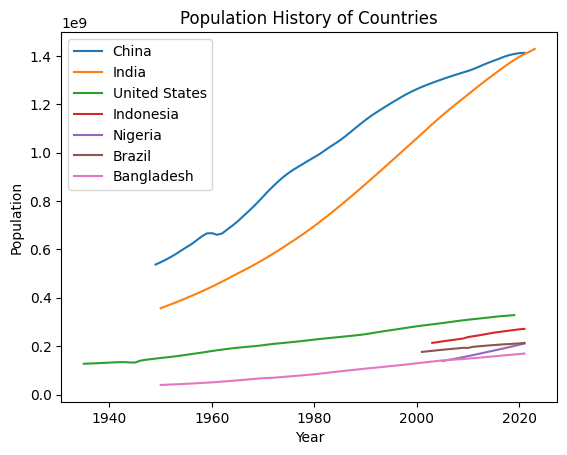

In [45]:
# Plot population history for each country
import matplotlib.pyplot as plt

for name, df in tables.items():
    if name != 'Pakistan':  # We got the wrong table for pakistan
        # Convert years to int (dropping anything else)
        yc = year_col(df)
        df[yc] = pd.to_numeric(df[year_col(df)], errors='coerce')

        # Convert population in thousands to actual count
        pc = pop_col(df)
        df[pc] = pd.to_numeric(df[pop_col(df)], errors='coerce')
        if 'thousands' in pc.lower():
            df[pc] = df[pc] * 1000

        df = df.dropna(subset=[yc, pc])

        # Plot
        plt.plot(df[yc], df[pc], label=name)

plt.xlabel('Year')
plt.ylabel('Population (billions)')
plt.title('Population History of Countries')
plt.legend()
plt.show()